# Practical session on recommender systems with Movielens

MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota. 
 
This data set consists of:  
	* 100,000 ratings (1-5) from 943 users on 1682 movies.  
	* Each user has rated at least 20 movies.  
        * Simple demographic info for the users (age, gender, occupation, zip) 
        
        
This notebook aims at showing how to build a simple recommender system on the Movielens data set by comparing different factorization approaches, namely
- singular value decomposition (SVD),  
- weighted singular value decomposition (wSVD),  
- alternated least quare (ALS) for the wSVD,   
- stochastic gradient descent (SGD) using pytorch.  

Next step would be to use the factorization as an embedding, that is the input of a deep network in charge of prediction the rattings. However, to get nice results, this may require a larger dataset...


## The movielens data

1\. The MovieLens100k dataset   
1.1  What is the Movie Lens data set https://grouplens.org/datasets/movielens/?     
1.2  Why is it preferable to begin with the MovieLens 100K Dataset?       
1.3  download the MovieLens100k dataset that is the ml-100k.zip file  (size: 5 MB) from https://grouplens.org/datasets/movielens/100k/     

Download and unzip ml-100k.zip
        
The 'u.data' file contains the full u data set, 100000 ratings by 943 users on 1682 items.    
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered.    
              This is a tab separated list of user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

https://grouplens.org/datasets/movielens/100k/   
download and unzip ml-100k.zip

from google.colab import drive
drive.mount('c')

import pandas as pd
import numpy as np
from numpy import random
import scipy
import scipy.sparse
from time import time

data_dir = "c/content/drive/ml-100k/"
data_shape = (943, 1682)

df = pd.read_csv("/content/c/My Drive/ml-100k/u.data", sep="\t", header=None)
values = df.values
values[:, 0:2] -= 1

In [36]:
import pandas as pd
import numpy as np
np.random.seed(0)
from numpy import random
import scipy
import scipy.sparse
from time import time


data_dir = "ml-100k/"
data_shape = (943, 1682)

names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(data_dir + "u.data", sep="\t", names = names, header=None)
values = df.values
values[:, 0:2] -= 1  # in python 1 is 0

In [37]:
df.head(5)

user_id  item_id  rating  timestamp
0      195      241       3  881250949
1      185      301       3  891717742
2       21      376       1  878887116
3      243       50       2  880606923
4      165      345       1  886397596

In [38]:
ind = np.random.permutation(range(100000))
inda = ind[0:90000]
indt = ind[90000:]

import scipy.sparse

M = scipy.sparse.csr_matrix((values[:, 2], (values[:, 0], values[:, 1])), dtype=float, shape=data_shape)
Ma = scipy.sparse.csr_matrix((values[inda, 2], (values[inda, 0], values[inda, 1])), dtype=float, shape=data_shape)
Mt = scipy.sparse.csr_matrix((values[indt, 2], (values[indt, 0], values[indt, 1])), dtype=float, shape=data_shape)

nt = np.sum(Mt>.5)

In [39]:
import numpy as np
from scipy.sparse import csr_matrix

# Example sparse matrix
data = np.array([1, 2, 3, 4, 5, 6])
rows = np.array([0, 0, 1, 1, 2, 2])
cols = np.array([0, 2, 0, 2, 0, 2])
matrix = csr_matrix((data, (rows, cols)), shape=(3, 3), dtype=float)
print(matrix.data)

# Calculate the global mean
global_mean = matrix.data.mean()

# Subtract the global mean from non-zero elements
matrix.data -= global_mean

global_mean = Ma.data.mean()
print('moyenne : {0:.3f}'.format(global_mean))
print(matrix.data)

[1. 2. 3. 4. 5. 6.]
moyenne : 3.530
[-2.5 -1.5 -0.5  0.5  1.5  2.5]


In [40]:
moy = np.sum(Ma)/np.sum(Ma>.5)
print('moyenne : {0:.3f}'.format(moy))

moyenne : 3.530


In [41]:
Mask = Ma>.5
Maskt = Mt>.5

In [45]:
print(Maskt)

  (0, 0)	True
  (0, 3)	True
  (0, 21)	True
  (0, 23)	True
  (0, 35)	True
  (0, 52)	True
  (0, 67)	True
  (0, 69)	True
  (0, 90)	True
  (0, 93)	True
  (0, 99)	True
  (0, 105)	True
  (0, 116)	True
  (0, 148)	True
  (0, 170)	True
  (0, 172)	True
  (0, 185)	True
  (0, 187)	True
  (0, 192)	True
  (0, 210)	True
  (0, 219)	True
  (0, 224)	True
  (0, 258)	True
  (1, 9)	True
  (1, 13)	True
  :	:
  (941, 281)	True
  (941, 477)	True
  (941, 495)	True
  (941, 606)	True
  (941, 660)	True
  (941, 1049)	True
  (942, 40)	True
  (942, 55)	True
  (942, 78)	True
  (942, 116)	True
  (942, 126)	True
  (942, 184)	True
  (942, 185)	True
  (942, 230)	True
  (942, 402)	True
  (942, 405)	True
  (942, 449)	True
  (942, 565)	True
  (942, 569)	True
  (942, 654)	True
  (942, 764)	True
  (942, 795)	True
  (942, 940)	True
  (942, 1010)	True
  (942, 1043)	True


In [6]:
Merr = Mt  - Maskt.multiply(moy)
err = np.sum(Merr.power(2))/nt  
print('Error baseline: {0:.3f}'.format(err))

Error baseline: 1.285


In [7]:
err = np.mean((Mt.data - moy)**2)
print('Error baseline: {0:.3f}'.format(err))
erra = np.mean((Ma.data - moy)**2)
print('Error baseline: {0:.3f}'.format(erra))

Error baseline: 1.285
Error baseline: 1.265


In [8]:
Mc = Ma - moy*Mask
Mt = Mt - moy*Maskt

import scipy.sparse.linalg


t0 = time()
U, D, Vt = scipy.sparse.linalg.svds(Mc,k=50)
t1 = time()
print('\n temps de calcul : {0:.3f}'.format( t1 - t0 ))

U = U[:, ::-1]
D = D[::-1]
Vt = Vt[::-1, :]


 temps de calcul : 0.120


In [10]:
from time import time

p = 20
err_svd = np.zeros(p)
t0 = time()
for i in range(1,pm+1):
   Mh = np.dot(np.dot(U[:,0:i],np.diag(D[0:i])),Vt[0:i,:])
   Merr = Mt  - Maskt.multiply(Mh)
   err_svd[i-1] = np.sum(Merr.power(2))/nt  

t1 = time()
print('\n temps de calcul : {0:.3f}'.format( t1 - t0 ))


 temps de calcul : 0.066


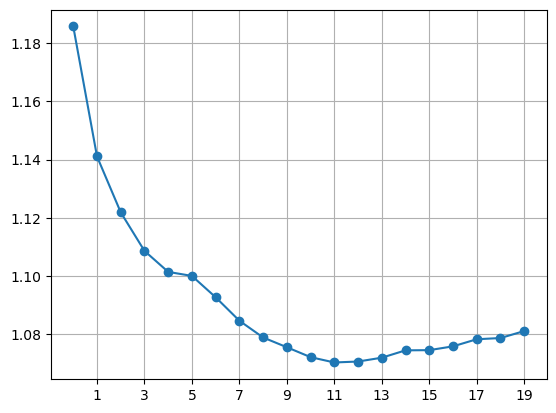

In [11]:
import matplotlib.pyplot as plt

plt.plot(err_svd,'o-')
plt.grid(True)
plt.xticks(np.arange(1, p, step=2))
plt.show()

## Weighted SVD (wSVD)

4\. Check if you can improve the prediuctions using the weighted SVD    
4.1 First use the approach proposed by  Marlin or Srebro and Jaakkola implementing the following sequence:
$$
\begin{array}{rll}
loop & & & \\
&F &=& W \odot M  + (1-W) \odot Z^{k} \\
&U,D, V &=& svd(F) \\
&Z^{k+1} &=& U D V^\top 
\end{array}
$$
where $\odot$ denote the element wise product of two matices.

For details see for instance:

- Marlin, B. (2004). Collaborative filtering: A machine learning perspective (pp. 2239-2239). Toronto: University of Toronto.

- Srebro, N., & Jaakkola, T. (2003). Weighted low-rank approximations. In Proceedings of the 20th International Conference on Machine Learning (ICML-03) (pp. 720-727).

In [12]:
nb_iter_max = 30 # 10

k = 15
epsilon = 1e-3
Mest = 0*Mc; # initial guess is 0
errw = np.zeros(k)
un = np.ones((943, 1682))
un_m_Mask = scipy.sparse.csr_matrix(un-Mask)

t0 = time()
for i in range(1,k+1):
   for ii in range(1,30):
        Y = Mc + un_m_Mask.multiply(Mest);
        U, D, Vt = scipy.sparse.linalg.svds(Y,k=i)
        Mest = np.dot(np.dot(U,np.diag(D)),Vt)

   Merr = Mt  - Maskt.multiply(Mest)
   errw[i-1] = np.sum(Merr.power(2))/nt  

t1 = time()
print('\n Computing time: {0:.3f}'.format( t1 - t0 ))


 Computing time: 39.624


In [13]:
#from numba import jit

#@jit()
def wSVD():
    Mest = 0*Mc; # initial guess is 0
    for i in range(1,k+1):
       for ii in range(1,30):
            Y = Mc + un_m_Mask.multiply(Mest);
            U, D, Vt = scipy.sparse.linalg.svds(Y,k=i)
            Mest = np.dot(np.dot(U,np.diag(D)),Vt)

       Merr = Mt  - Maskt.multiply(Mest)
       errw[i-1] = np.sum(Merr.power(2))/nt  

nb_iter_max = 30 # 10
k = 15
epsilon = 1e-3
Mest = 0*Mc; # initial guess is 0
errw = np.zeros(k)
un = np.ones((943, 1682))
un_m_Mask = scipy.sparse.csr_matrix(un-Mask)

t0 = time()
wSVD()
t1 = time()
print('\n Computing time: {0:.3f}'.format( t1 - t0 ))



 Computing time: 39.180


In [14]:
whos

Variable      Type                          Data/Info
-----------------------------------------------------
D             ndarray                       15: 15 elems, type `float64`, 120 bytes
M             csr_matrix                      (0, 0)	5.0\n  (0, 1)	3.<...>7)	3.0\n  (942, 1329)	3.0
Ma            csr_matrix                      (0, 1)	3.0\n  (0, 2)	4.<...>7)	3.0\n  (942, 1329)	3.0
Mask          csr_matrix                      (0, 1)	True\n  (0, 2)	T<...>	True\n  (942, 1329)	True
Maskt         csr_matrix                      (0, 0)	True\n  (0, 3)	T<...>	True\n  (942, 1043)	True
Mc            csr_matrix                      (0, 1)	-0.5298888888888<...>1329)	-0.5298888888888889
Merr          csr_matrix                      (0, 0)	1.23139740729833<...>1043)	-1.6268029962327792
Mest          csr_matrix                      (0, 1)	-0.0\n  (0, 2)	0<...>	-0.0\n  (942, 1329)	-0.0
Mh            ndarray                       943x1682: 1586126 elems, type `float64`, 12689008 bytes (12.1011

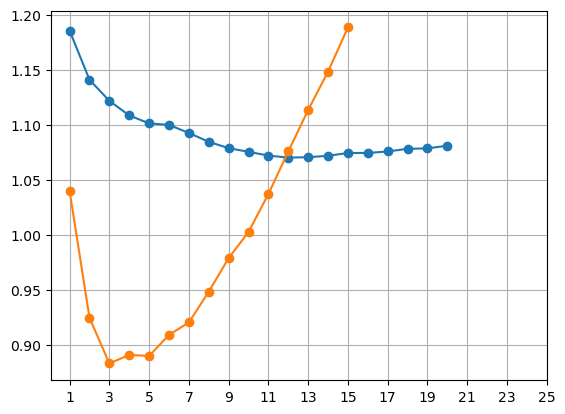

In [15]:
plt.plot(range(1,len(err_svd)+1),err_svd, 'o-')
plt.plot(range(1,len(errw)+1),errw, 'o-')
plt.grid(True)
plt.xticks(np.arange(1, 26, step=2))
plt.show()

## Alternating Least Squares (ALS)

5\. Solve the penalized weighted SVD problem 
$$
\min_{U,V} \|M - UV^\top\|_W^2 + \lambda \|U\|^2+ \lambda \|V\|^2
$$
where $\|M\|_W^2 = \sum_{ij} W_{ij} M_{ij}^2$.
Use $\lambda = 5$ and implement the penalised Alternating Least Square(ALS) described as follows:

Initialize $U$ and $V$ with the SVD on the full matrix
$$
\begin{array}{rl}
loop &  \\
&  \text{compute } U \text{ that } \min_{U} \|M - UV^\top\|_W^2 + \lambda \|U\|^2 \text{ with a fix } V \\
&  \text{compute } V \text{ that }  \min_{V} \|M - UV^\top\|_W^2 + \lambda \|V\|^2 \text{ with a fix } U 
\end{array}
$$
For details see for instance:

- Y. Hu, Y. Koren, and C. Volinsky. Collaborative filtering for implicit feedback datasets. In Proc. of 8th
IEEE Int. Conf. on Data Mining, ICDM '08, pages
263{272, Pisa, Italy, 2008.

In [35]:
n,p = Mc.shape
lam = 2
Kmax = 10
err_als = np.zeros(Kmax-1)

t0 = time()
for k in range(1,Kmax):
    I = np.eye(k)
    erri = np.zeros((20+1,))
    U, D, Vt = scipy.sparse.linalg.svds(Mc,k=k)
    Vt = np.dot(np.diag(D),Vt)

    Merr = Mt  - Maskt.multiply(U@Vt)
    erri[0] = np.sum(Merr.power(2))/nt  

    for nb in range(0,20):
        for j in range(0,p):
           indj = Mask[:,j].nonzero()[0]
           Vt[:,j] = np.linalg.solve(U[indj,:].T@U[indj,:] + lam*I,U[indj,:].T@Mc[indj,j]).T

#        Merr = Mt  - Maskt.multiply(U@Vt)
#        erri1 = np.sum(Merr.power(2))/nt  
#        print(erri1)
  
        for i in range(0,n):
           indi = Mask[i,:].nonzero()[1]
           U[i,:] = np.linalg.solve(Vt[:,indi]@Vt[:,indi].T + lam*I,Vt[:,indi]@Mc[i,indi].T).T

        Merr = Mt  - Maskt.multiply(U@Vt)
        erri[nb+1] = np.sum(Merr.power(2))/nt  

    print('test error: {0:.3f}'.format(erri[nb+1]))

    err_als[k-1] = erri[nb+1]
    
t1 = time()
print('\n computing time: {0:.3f}'.format( t1 - t0 ))


 test error: 1.017

 test error: 0.914

 test error: 0.874

 test error: 0.882

 test error: 0.900

 test error: 0.913

 test error: 0.923

 test error: 0.938

 test error: 0.962

 computing time: 109.982


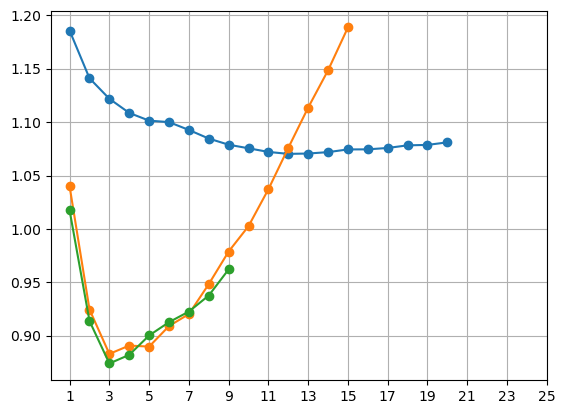

In [17]:
plt.plot(range(1,len(err_svd)+1),err_svd, 'o-')
plt.plot(range(1,len(errw)+1),errw, 'o-')
plt.plot(range(1,len(err_als)+1),err_als, 'o-')
plt.grid(True)
plt.xticks(np.arange(1, 26, step=2))
plt.show()

# Stochastic gradient dscent (SGD)

## Recommender system with pytorch

6\. Implement Stochastic gradient descent (SGD) using PyTorch

Pick a rating $m_{i,j}$ for user $i$ and for movie $j$. 
Given two matrices $U, n \times k$ and $V, n \times k$, 
is $u_{i\bullet}$ denotes line $i$ of matrix $U$ while $v_{\bullet j}$ is the transpose of $V$'s column $j$, the prediction for $m_{i,j}$ is given by
$$
\hat m_{i,j} = u_{i\bullet} v_{\bullet j}.
$$
The associated error is 
$$
err = \frac{1}{2}\displaystyle \sum_{ij} (\hat m_{i,j} - m_{i,j})^2  + \frac{\lambda}{2} \|u_i\|^2 +  \frac{\lambda}{2} \|v_j\|^2,
$$
so that gradient updates are given by, for a stepsize $\rho$,
$$
u_i \leftarrow u_i -  \rho\bigl((\hat m_{i,j} - m_{i,j}) v_j^\top + \lambda u_i\bigr) \\
v_j \leftarrow v_j -  \rho\bigl((\hat m_{i,j} - m_{i,j}) u_i \;\, + \lambda v_j\bigr).
$$
The efficiency of the algorithm depends on the parameters:
* $\rho$ the gradient stepsize  
* $\lambda$, the regularization parameter
* $k$, the number of factors
* $b$, the size of the minibatches
* the initialization of $U$ and $V$

See also https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

https://github.com/cemoody/simple_mf/tree/master/notebooks

In [18]:
import torch

La = np.vstack((values[inda, 0], values[inda, 1], values[inda, 2])).T
indices = np.vstack((La[:,0], La[:,1]))
i = torch.LongTensor(indices)
v = torch.FloatTensor(La[:,2]-moy)
Mc_torch = torch.sparse.FloatTensor(i, v, torch.Size(data_shape)).to_dense()

t0 = time()
u, s, v = torch.svd(Mc_torch)
t1 = time()
print('\n temps de calcul : {0:.3f}'.format( t1 - t0 ))
print(np.around(s[0:8].detach().cpu().numpy(),4))
print(np.around(D[0:8],4))

/var/folders/ck/0nwhvwjn3kb593xmnwkkg2y00000gp/T/ipykernel_45847/55894940.py:7: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1687676957570/work/torch/csrc/utils/tensor_new.cpp:607.)
  Mc_torch = torch.sparse.FloatTensor(i, v, torch.Size(data_shape)).to_dense()



 temps de calcul : 0.373
[80.8727 64.9116 54.5617 47.751  40.0251 37.577  35.4539 33.4528]
[32.9928 33.4528 35.4539 37.577  40.0251 47.751  54.5617 64.9116]


In [19]:
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SparseAdam,Adam,Adagrad,SGD
from time import time

if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(device)

cpu


In [20]:
La = np.vstack((values[inda, 0], values[inda, 1], values[inda, 2])).T
Las = []
for i in range(len(La)):
    Las.append(tuple(La[i,:]))

In [21]:
# The model define as a class, inheriting from nn.Module
class MF_with_mean(nn.Module):
    
    #(a) Init
    def __init__(self,nb_users,nb_items,latent_size):
        super(MF_with_mean, self).__init__()
        
        #Embedding layers
        self.users = nn.Embedding(nb_users, latent_size)        
        self.items = nn.Embedding(nb_items, latent_size)
        #The mean bias
        self.mean = nn.Parameter(torch.FloatTensor(1,).fill_(3))
        
        #initialize weights with very small values
        nn.init.normal_(self.users.weight,0,0.01)
        nn.init.normal_(self.items.weight,0,0.01)

    
    # (b) How we compute the prediction (from input to output)
    def forward(self, user, item): ## method called when doing ClassicMF(user,item)
        
        embed_u,embed_i = self.users(user).squeeze(1),self.items(item).squeeze(1)
        out = self.mean + (embed_u*embed_i).sum(1) #To Complete

        return out, embed_u, embed_i  # We return prediction + weights to regularize them

In [22]:
#(b) Collate function => Creates tensor batches to feed model during training
# It can be removed if data is already tensors (torch or numpy ;)
def tuple_batch(l):
    '''
    input l: list of (user,item,rating tuples)
    output: formatted batches (in torch tensors)

    takes n-tuples and create batch
    text -> seq word #id
    '''
    users, items, ratings = zip(*l) 
    users_t = torch.LongTensor(users)
    items_t = torch.LongTensor(items)
    ratings_t = torch.FloatTensor(ratings)
    
    return users_t, items_t, ratings_t

def loss_func(pred,ratings_t,reg,*params):
    '''
    mse loss combined with l2 regularization.
    params assumed 2-dimension
    '''
    mse = F.mse_loss(pred,ratings_t,reduction='sum')
    l2 = 0
    for p in params:
        l2 += torch.mean(p.norm(2,-1))
        
#    return (mse/pred.size(0)) + reg*l2 , mse
    return (mse) + reg*l2 , mse

In [23]:
from torch.utils.data import DataLoader

BATCH_SIZE = 2*64
dataloader_train = DataLoader(Las, batch_size=BATCH_SIZE, shuffle=True, 
                                num_workers=0, collate_fn=tuple_batch)

t0 = time()
err_torch = []
for k in range(2,25):
  model = MF_with_mean(n, p, k)
  optimizer = Adam(model.parameters(),lr = 0.001)   # ,lr=0.001
  loss_fn = nn.MSELoss()
  reg = 0.01

  for ii in range(10):
      for users_t,items_t,ratings_t in dataloader_train:
          model.train()     # set the model on train mode
          model.zero_grad() # reset gradients
          
          #                 (c) predictions are made by the model
          pred,*params = model(users_t,items_t)
          
          #                 (d) loss computed on predictions, we added regularization
          loss,mse_loss = loss_func(pred,ratings_t,reg,*params)       
          loss.backward()  #(e) backpropagating to get gradients       
          optimizer.step() #(f) updating parameters    

      # compute the test error      
  uvt = torch.mm(model.users.weight,model.items.weight.T) 
  Mh =  uvt.data.numpy()
  Mh = Mh + (model.mean.data.numpy())*np.ones(Mh.shape)
  Merr = Mt + moy*Maskt  - Maskt.multiply(Mh)  # a.data.numpy() convert torch tensor a into a numpy array
  err = np.sum(Merr.power(2))/nt  
  print('PyTorch factorization  error : {0:.3f}'.format(err))
  err_torch.append(err)

t1 = time()
print('\n computing time: {0:.3f}'.format( t1 - t0 ))

PyTorch factorization  error : 0.925
PyTorch factorization  error : 0.952
PyTorch factorization  error : 0.919
PyTorch factorization  error : 0.889
PyTorch factorization  error : 0.906
PyTorch factorization  error : 0.897
PyTorch factorization  error : 0.898
PyTorch factorization  error : 0.893
PyTorch factorization  error : 0.879
PyTorch factorization  error : 0.875
PyTorch factorization  error : 0.879
PyTorch factorization  error : 0.866
PyTorch factorization  error : 0.866
PyTorch factorization  error : 0.865
PyTorch factorization  error : 0.866
PyTorch factorization  error : 0.861
PyTorch factorization  error : 0.867
PyTorch factorization  error : 0.860
PyTorch factorization  error : 0.860
PyTorch factorization  error : 0.863
PyTorch factorization  error : 0.858
PyTorch factorization  error : 0.857
PyTorch factorization  error : 0.856

 computing time: 127.782


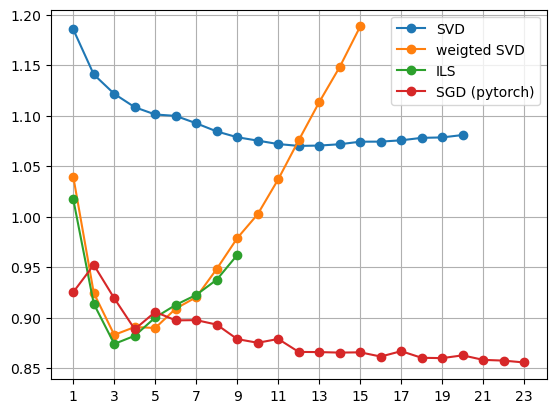

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(err_svd)+1),err_svd, 'o-')
plt.plot(range(1,len(errw)+1),errw, 'o-')
plt.plot(range(1,len(err_als)+1),err_als, 'o-')
plt.plot(range(1,len(err_torch)+1),err_torch, 'o-')
plt.legend(('SVD','weigted SVD','ILS','SGD (pytorch)'))
plt.grid(True)
plt.xticks(np.arange(1, 25, step=2))
plt.show()

## Conclusion

Stochastic gradient descent, when properly used, gives the best results,  in a reasonable and scalable computing time.

|method| MSE (test)| Nb of factors| Computing time (in sec.)
|------:|:-----:|:-----:|:-----:|
|mean| 1.279|0 | 0.
|SVD | 1.070| 13 | 0.051
|wSVD| 0.880| 3 |54.
|ALS | 0.875| 4 |225.
|SGD | 0.849|21 | 229.

https://surprise.readthedocs.io/en/stable/matrix_factorization.html?highlight=SVD#surprise.prediction_algorithms.matrix_factorization.SVD

In [25]:
from surprise import accuracy, Dataset, SVD, SVDpp
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [26]:
data = Dataset.load_builtin('ml-100k')
algo = SVDpp()
#cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset, testset = train_test_split(data, test_size=0.1,shuffle=True)

# We'll use the famous SVD algorithm.
algo = SVDpp()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
err = accuracy.rmse(predictions)
print(np.round(err*err,3))

RMSE: 0.9121
0.832


In [ ]:
0.93105187*0.93105187

In [ ]:
whos